In [ ]:
"""
This is the optimal, fast, and lightweight solution to the problem.
This one-layered neural network must only be applied to the pre-processed data exported from MA.ipynb notebook.

The output is a trained model that can predict the future of the pre-processed data.
The resource manager will use the output to decide how to auto-scale the resources to prevent violating the SLA while minimizing the required resources, thus maximizing the profit.

This solution is to be benchmarked with MA_LSTM_2.ipynb, which is a complex yet powerful, accurate, and highly optimized solution that needs to be learned from non-processed data.

"""

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import datetime as dt
import copy
from matplotlib import pyplot

import numpy as np
import pandas as pd
from time import time as T

from math import sqrt
#from numpy import concatenate
from matplotlib import pyplot
#from pandas import read_csv
#from pandas import DataFrame
#from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [3]:
headers = ['Unnamed: 0', 'seconds_passed','second','minute','hour','day_of_week','day_of_month','month','season','year','VM_load','requests_per_second','disk_usage']
usecols = copy.deepcopy(headers)
usecols.remove('seconds_passed')
usecols.remove('requests_per_second')
usecols.remove('disk_usage')
usecols.remove('second')
usecols.remove('minute')
usecols.remove('year')
# load data
def parse_date_time(x):
    return dt.datetime.strptime(x, '%Y %m %d %H %M %S')
dataset = pd.read_csv('data.csv', usecols=usecols, index_col=0)
dataset.index.name = 'index'
#dataset.drop('Unnamed: 0', axis=1, inplace=True)
# dataset.drop('seconds_passed', axis=1, inplace=True)
# dataset.drop('second', axis=1, inplace=True)
# dataset.drop('minute', axis=1, inplace=True)
dataset = dataset[['hour', 'VM_load', 'day_of_month', 'month', 'season', 'day_of_week']]
dataset.head()

D:\Users\mohammad_navid\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,hour,VM_load,day_of_month,month,season,day_of_week
index,,,,,,
0,0,1.046394,1,1,0,1
1,0,1.037863,1,1,0,1
2,0,1.043727,1,1,0,1
3,0,1.086876,1,1,0,1
4,0,1.109945,1,1,0,1


In [4]:
MA_dataset = pd.read_csv('MV.csv', index_col=0)

D:\Users\mohammad_navid\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
MA_dataset.head()

,moving_average,lower_bound,higher_bound
0,0.928326,0.687118,1.391741
1,0.928813,0.687345,1.392126
2,0.929545,0.687573,1.392511
3,0.930487,0.687800,1.392895
4,0.931383,0.688027,1.393280


In [7]:
dataset = dataset[:2072100]
print(len(dataset))
print(len(MA_dataset))

2072100
2072100


In [8]:
dataset['VM_load'] = MA_dataset['higher_bound']

D:\Users\mohammad_navid\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [10]:
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

In [11]:

# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_steps = 3 
n_features = 5
# frame as supervised learning
reframed = series_to_supervised(scaled, n_steps, 1)
print(reframed.shape)

(2072097, 24)


In [12]:
# split into train and test sets
values = reframed.values
n_train_hours = int(0.8 * values.shape[0])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_steps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_steps, n_features))
test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1657677, 15) 1657677 (1657677,)
(1657677, 3, 5) (1657677,) (414420, 3, 5) (414420,)


In [13]:
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(RepeatVector(1))
# model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(Dense(25, activation='relu')
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [14]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1657677 samples, validate on 414420 samples
Epoch 1/10
 - 95s - loss: 7.9185e-04 - val_loss: 0.0714
Epoch 2/10
 - 96s - loss: 1.4543e-04 - val_loss: 0.0134
Epoch 3/10
 - 97s - loss: 8.9510e-05 - val_loss: 0.0104
Epoch 4/10
 - 95s - loss: 1.3392e-04 - val_loss: 0.0454
Epoch 5/10
 - 94s - loss: 8.6323e-05 - val_loss: 0.0034
Epoch 6/10
 - 97s - loss: 5.5828e-05 - val_loss: 0.0113
Epoch 7/10
 - 100s - loss: 3.6345e-05 - val_loss: 0.0049
Epoch 8/10
 - 95s - loss: 5.4854e-05 - val_loss: 0.0159
Epoch 9/10
 - 95s - loss: 2.5881e-05 - val_loss: 0.0017
Epoch 10/10
 - 93s - loss: 3.3177e-05 - val_loss: 0.0010


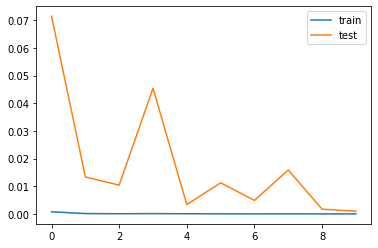

In [15]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_steps*n_features))

In [17]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [18]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.731


<IPython.core.display.Javascript object>


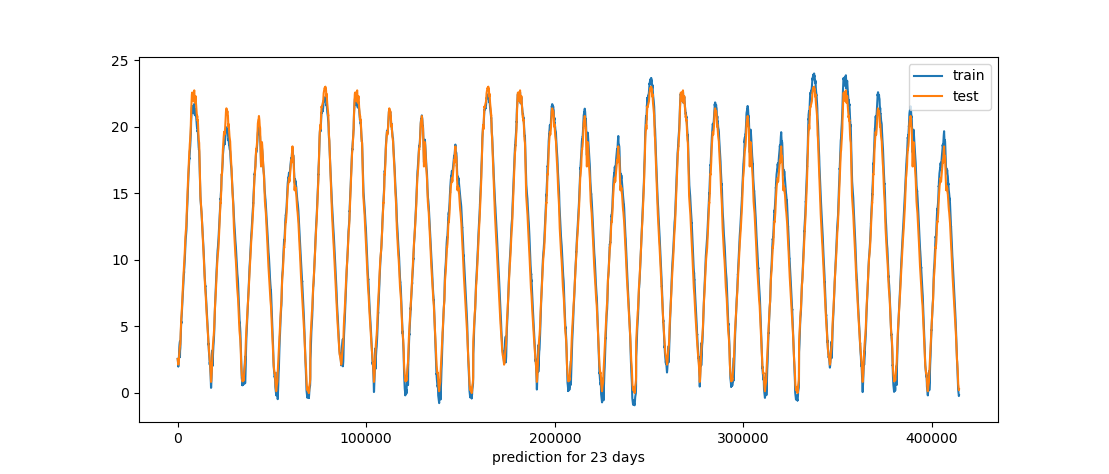

In [24]:
pyplot.plot(inv_yhat, label='train')
pyplot.plot(inv_y, label='test')
pyplot.xlabel('prediction for 23 days')
pyplot.legend()
#pyplot.savefig('23days.eps', format='eps')
pyplot.show()

<IPython.core.display.Javascript object>


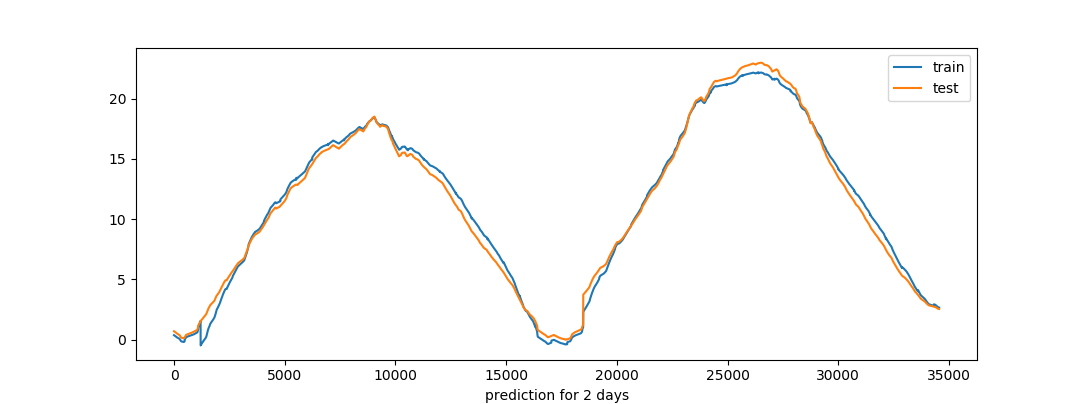

In [23]:
day = int(24 * 3600 /5)
pyplot.plot(inv_yhat[3*day:5*day], label='train')
pyplot.plot(inv_y[3*day:5*day], label='test')
pyplot.xlabel('prediction for 2 days')
pyplot.legend()
#pyplot.savefig('5000sec.eps', format='eps')
pyplot.show()